In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
#meta
block_size = 3 # context length: how many characters do we take to predict the next one?

featureDim = 30 # features per character in context of 3 characters
hiddenNeurons = 200

bachSize = 64


In [3]:
# read words
words = open('names.txt', 'r').read().splitlines()

In [4]:
#Tokenization
charsInNames = sorted(list(set(''.join(words))))

stoi = {'.': 0}# Initialize stoi with '.' mapped to 0
stoi.update({ch: i for i, ch in enumerate(charsInNames, 1)})

itos = {i:ch for ch, i in stoi.items()}
# print(itos)

In [5]:
# build the dataset
def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  # print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


In [6]:
# build parameers
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, featureDim), generator=g, requires_grad = True)
W1 = torch.randn((block_size*featureDim, hiddenNeurons), generator=g, requires_grad = True)
b1 = torch.randn(hiddenNeurons, generator=g, requires_grad = True)
W2 = torch.randn((hiddenNeurons, 27), generator=g, requires_grad = True)
b2 = torch.randn(27, generator=g, requires_grad = True)
parameters = [C, W1, b1, W2, b2]

In [7]:
# number of parameters in total
sum(p.nelement() for p in parameters) 

24437

In [8]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [9]:
lri = []
lossi = []
stepi = []

In [10]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (bachSize,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, block_size*featureDim) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

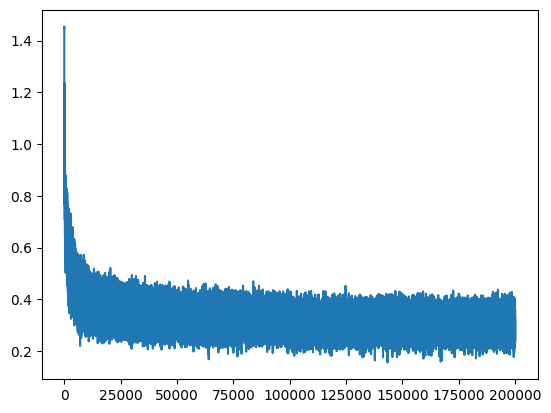

In [11]:
plt.plot(stepi, lossi)

In [12]:
def lossFunc (C, Y):
    h = torch.tanh(C.view(-1, block_size*featureDim) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)
    return loss


In [13]:
print('loss train:', lossFunc(C[Xtr], Ytr).item())
print('loss DEV:', lossFunc(C[Xdev], Ydev).item())

loss train: 2.046786069869995
loss DEV: 2.138624429702759


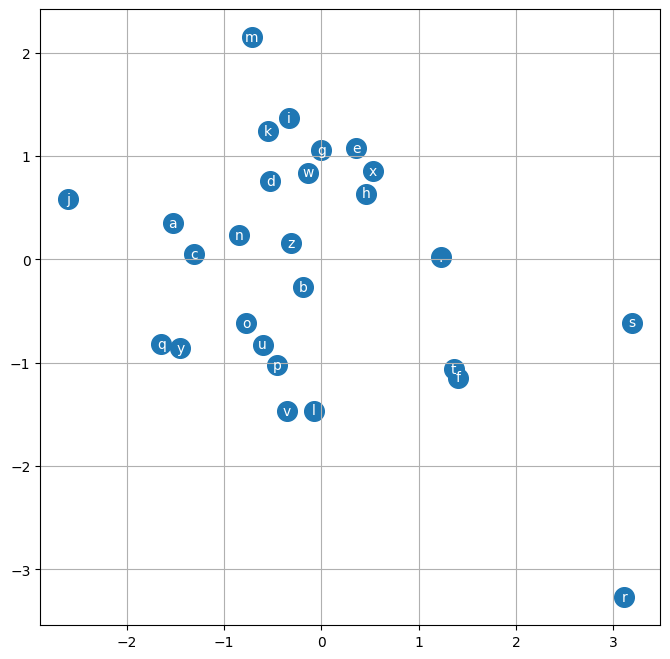

In [14]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)

for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')

plt.grid('minor')

In [15]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [16]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 30])

In [17]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

montaymynahiellend.
rylee.
emmaniejdon.
graie.
korelin.
shi.
jen.
eden.
estanar.
kayzion.
kamin.
shubergian.
jest.
jair.
jennie.
terian.
brence.
rya.
juliekshiva.
miskona.
